# Objective

Implement a neural network.


### Function implementations


* sigmoid
* softmax
* cross entropy log loss (binary and categorical)

### Layer implementations


* Standardization
* Matmul
* Activation (sigmoid, softmax)
* Log loss output
* Batch normalization (TBD)

Mathjax formulas get corrupted in github.

### Classifier Implementations

* Binary classifiation with (matmul-loss) layers.
* Categorical classifiation with (matmul-ReLu-matmul-Relu-loss) layers.

# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

---

# Neural network overview

Structure of the network and how forward and backward propagations work.

<img src="image/nn_diagram.png" align="left">

# Concepts 

## Objective function

The network trains the layers so as to minimize the objective function ```L``` which calculates the loss. Each layer at ```i``` is a function $f_i$ which takes an input $X_i$ from a previous layer and outputs $Y_i = f(X_i)$. The post layers of the form an objective function $L_i$ for the layer: $L = L_i(Y_i)$. 


<img src="image/nn_functions.png" align="left">

## Forward path

The process where each layer ```i``` calculate its output $Y_i = f(X_i)$ and forward it to the next layer(s) as their input $X_{i+1}$.

## Backward path

The process of automatic differentication, or *back-propagation* where each layer calculates its gradient $\frac {\partial L_i(Y_i)}{\partial Y_i}$ , that is, the impact $Y_i$ will make on the objective ```L``` when it changes. With the gradient, we can apply the gradient descent $X_i = X_i - \lambda  \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i }{\partial X_i}$ to update $X_i$ that would reduce the objective ```L```.

## Cycle

A round-trip of a forward path and a backward path with a batch data set $(X, T)$. How many cycles to happen with each batch is an implementation decision. 

## Epoch

Total cycles to consume the entire training data.

---

# Terminologies

## X
A batch input to a layer. Matrix shape is ```(N, D)```.

* ```N``` : Number of rows in a batch X, or batch size
* ```D``` : Number of features in a data in X.


## T
Labels for X. There are two formats available for the label.

#### One Hot Encoding (OHE) labels

When a neural network predicts a class out of ```3``` classes for an input ```x``` and the correct class is ```2```, then the label ```t``` is specified as ```t = [0, 1, 0]```.

$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

#### Index labels

The label ```t``` is specified as ```t = 2```. 

$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \end{align*}
$

## W
A set of weight parameters of a node in a Matmul layer. Shape is ```(M, D)```.

* ```M``` : Number of nodes in a layer



# Matrix order

Use the row-order matrix. For instance, the weight matrix ```W``` of a Matmul layer has a shape ```(M, D)``` where each row in ```W``` represents a node in the layer. It will be efficient to use the column order matrix of shape ```(D, M)``` for ```W``` so that the matrix multiplication at a Matmul layer can be executed as ```X@W```  which is a ```shape:(N,D) @ shape:(D,M)``` operation without transpose. 

However, for the purpose of consistency and clarity, use the shape ```W:(M, D)``` although it will cause transposes ```W.T``` at the Matmul operations, and revese transposing ```dL/dW.T``` to ```dL/dW``` when updating ```W``` at the gradient descents.


---

# Python & Jupyter setups

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [3]:
import inspect
from functools import partial
import copy
import logging
import numpy as np
import matplotlib.pyplot as plt

### Jupyter notebook

In [4]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

%load_ext autoreload
%autoreload 2

### Matplotlib

In [5]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [6]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

---

---

# Normalization Layer
Apply normalization or use batch normaliation.

---

# Matmul layer

In [7]:
from common import (
    xavier,
    he,
    uniform
)
from layer.matmul import Matmul

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

### Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Batch Normalization Layer

* [Understanding the backward pass through Batch Normalization Layer](http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
<img src="image/bn_back_propagation.png" align="left" />
<img src="image/batch_normalization_steps_small.jpg" align="left" />

---

# Activation layer

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

#### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

#### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [8]:
from layer import CrossEntropyLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

def softmax(X: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
    """Softmax P = exp(X) / sum(exp(X))
    Args:
        X: batch input data of shape (N,M).
            N: Batch size
            M: Number of nodes
    Returns:
        P: Probability of shape (N,M)
    """
    name = "softmax"
    assert isinstance(X, float) or (isinstance(X, np.ndarray) and X.dtype == TYPE_FLOAT), \
        "X must be float or ndarray(dtype=TYPE_FLOAT)"

    # --------------------------------------------------------------------------------
    # exp(x-c) to prevent the infinite exp(x) for a large value x, with c = max(x).
    # keepdims=True to be able to broadcast.
    # --------------------------------------------------------------------------------
    C = np.max(X, axis=-1, keepdims=True)
    # exp = np.exp(X - C)
    exp = ne.evaluate("exp(X - C)")
    P = exp / np.sum(exp, axis=-1, keepdims=True)
    Logger.debug("%s: X %s exp %s P %s", name, X, exp, P)

    return P



## Foward path
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Backward path

### Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

The formula is calculated by chaing the gradient from ***cross-entropy-log-loss***, and the gradients of the steps in ***softmax***.

#### Gradient from the cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


####  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

#### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



#### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



#### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [9]:
from common import (
    cross_entropy_log_loss,
    OFFSET_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

def cross_entropy_log_loss(
        P: Union[np.ndarray, float],
        T: Union[np.ndarray, int],
        f: Callable = categorical_log_loss,
        offset: float = OFFSET_LOG
) -> np.ndarray:
    """Cross entropy log loss [ -t(n)(m) * log(p(n)(m)) ] for multi labels.
    Args:
        P: activation or probabilities from an activation function.
        T: labels
        f: Cross entropy log loss function f(P, T) where P is activation, T is label
        offset: small number to avoid np.inf by log(0) by log(0+offset)

    Returns:
        J: Loss value of shape (N,), a loss value per batch.

    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

        See transform_X_T for the format and shape of P and T.
    """
    name = "cross_entropy_log_loss"
    P, T = transform_X_T(P, T)
    if P.ndim == 0:
        assert False, "P.ndim needs (N,M) after transform_X_T(P, T)"
        # -----------------------------

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [10]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [11]:
N = 3
dJ = np.ones(N) / N
dJ

array([0.33333333, 0.33333333, 0.33333333])

---


# Gradient check

## Numerical gradient

The objective of back-propagation is to analytically calculate the gradient of the objective function $g(X_i) = \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i}{\partial X_i}$ at each layer. Suppose the shape of $X_i$ is ```(N, M)```. We can take an element of X at an index ```(n,m)``` and add a small change ```h```, then see what impact ```h``` makes by calculating the numerical gradient ```gn``` as: $
\begin {align*}
gn(X_i) = \frac {L_i(f_i(X_i+h)) - L_i(f_i(X_i-h))} {2h }
\end {align*}
$. Then $gn(X_i) \approx \; $gn(X_i)$ would assure the gradient calculation should be correct.

In [12]:
from common import (
    numerical_jacobian,
    OFFSET_DELTA
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, float],
        delta: Optional[TYPE_FLOAT] = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix that 


### Consideration

#### Instability of numerical calculations

A float number can have infinite length e.g. ```1/3``` in the real world, but a computer needs to approximate it by rounding it to fit into a limited storage. Need to assure numerical errors are prevented or detected while calculating gradient numerically. See [Numerical errors](numerical_errors.ipynb). 

### Example 

Comparing the analytical gradient and the numerical gradient of a logistic log loss ```L = -(1-T) * log(Z)``` where ```T = 0``` and ```Z=sigmoid(X)```.

In [13]:
def t_0_logistic_log_loss(X):
    """Logistic log loss function"""
    # --------------------------------------------------------------------------------
    # For numerical stability, re-forumulate the logistic log loss -(1-T)log(1-Z) as
    # X + log(1+exp(-X)).
    
    # By Reza.B
    # Let z=1/(1+p), p= e^(-x), then log(1-z)=log(p)-log(1+p), which is more stable
    # in terms of rounding errors (we got rid of division, which is the main issue 
    # in numerical instabilities). 
    # --------------------------------------------------------------------------------
    L = np.sum(X + np.log(1 + np.exp(-X)))
    return L.tolist()

def gradient_t_0_loss(X):
    return 1 / (1 + np.exp(-X))

X = np.random.uniform(-5, 5, (2,2))
print(f"The analytical and numerical gradients of the logistic log loss for X:\n{X}\n")

analytical_gradient = gradient_t_0_loss(X)
numerical_gradient = numerical_jacobian(t_0_logistic_log_loss, X)

print(f"Analytical gradient:\n{analytical_gradient}\n")
print(f"Numerical gradient:\n{numerical_gradient}")

The analytical and numerical gradients of the logistic log loss for X:
[[ 2.57494727 -4.05029049]
 [-4.05492884  1.49745458]]

Analytical gradient:
[[0.92923172 0.01711914]
 [0.01704127 0.81719453]]

Numerical gradient:
[[0.92923447 0.01711964]
 [0.0170397  0.8171952 ]]


---

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

In [14]:
%reload_ext autoreload
%autoreload 2
from common import (
    weights,
    transform_X_T,
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)
from data import (
    linear_separable
)
from optimizer import (
    Optimizer,
    SGD
)
from network import (
    train_binary_classifier
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot_categorical_predictions
)

## X

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [15]:
N = 500    # Number of plots
D = 2      # Number of features
from data import (
    linear_separable
)
X, T, V = linear_separable(d=D, n=N)
_X = np.c_[
    np.ones(N),     # Bias
    X
]
#print(f"X.shape {X.shape} T.shape {T.shape} W {V}")

### Classification goal

<IPython.core.display.Javascript object>


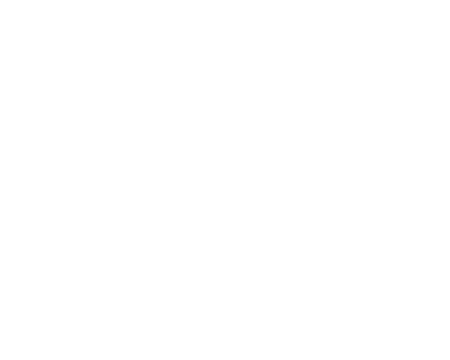

In [16]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X[T==0, 0], X[T==0, 1], c='red')
ax.scatter(X[T==1, 0], X[T==1, 1], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

## Train binary classifiers
1. Sigmoid binary classifier
2. Softmax binary classifier

In [17]:
%matplotlib notebook

def draw_training(X, W, _ax=None, _fig=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    #_ax.set_xlim(-3, 3)
    #_ax.set_ylim(-3, 3)
    #_ax.set_title(label=f"W: {W}")

    #_ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
    #_ax.scatter(X[T==1, 1], X[T==1, 2], c='green')
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.


## Sigmoid classifier training


<IPython.core.display.Javascript object>


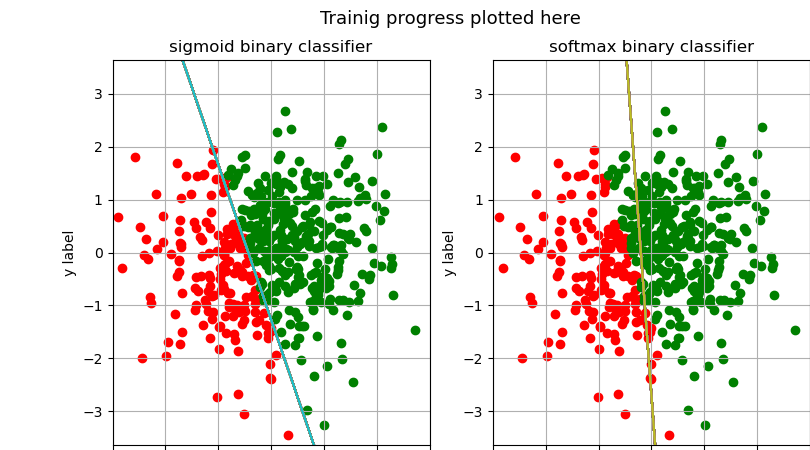

Train a sigmoid classifier to find optimal W (0.3631529846184986, 0.8953363216809309, 0.2578619414367642) for the boundary.
iteration 0 Loss 1.2736708761362885


array([[0.82613047, 1.9167621 , 0.65386184]])

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))
for i in range(2):
    ax[i].scatter(X[T==0, 0], X[T==0, 1], c='red')
    ax[i].scatter(X[T==1, 0], X[T==1, 1], c='green')
    ax[i].set_xlabel('x label')
    ax[i].set_ylabel('y label')
    ax[i].axis('equal')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].grid()

fig.suptitle('Trainig progress plotted here', fontsize=13)
ax[0].set_title("sigmoid binary classifier")
ax[1].set_title("softmax binary classifier")




print(f"Train a sigmoid classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 50

M = 1
W = weights.xavier(M, D+1)    # Xavier initialization for Sigmoid
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[0])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=sigmoid_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False,
    callback=draw
)

In [19]:
%lprun \
    -T train_sigmoid_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=sigmoid_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_sigmoid_classifier.log', 'r').read())

iteration 0 Loss 0.24720314920935754

*** Profile printout saved to text file 'train_sigmoid_binary_classifier.log'. 
Timer unit: 1e-06 s

Total time: 1.12744 s
File: /home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/network/test_020_one_layer_classifier.py
Function: train_classifier at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def train_classifier(
    49                                                   N: int,
    50                                                   D: int,
    51                                                   M: int,
    52                                                   X: np.ndarray,
    53                                                   T: np.ndarray,
    54                                                   W: np.ndarray,
    55                                                   log_loss_function: Callable,
    56                                                  

## softmax classifier training
Two class classification with softmax activation. 
Plots in the previous cell.

In [20]:
print(f"Train a softmax classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 100

M = 2                      
W = weights.he(M, D+1)
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[1])
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False, 
    callback=draw
)

Train a softmax classifier to find optimal W (0.3631529846184986, 0.8953363216809309, 0.2578619414367642) for the boundary.
iteration 0 Loss 0.8334945949945468
iteration 50 Loss 0.18121181987633195


array([[-0.42403923, -2.10978875, -0.15628577],
       [ 1.15475012,  1.73084903,  1.06418403]])

In [21]:
%lprun \
    -T train_softmax_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=softmax_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_softmax_classifier.log', 'r').read())

iteration 0 Loss 0.1400177439468588
iteration 50 Loss 0.12078897153905009

*** Profile printout saved to text file 'train_softmax_binary_classifier.log'. 
Timer unit: 1e-06 s

Total time: 2.33835 s
File: /home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/network/test_020_one_layer_classifier.py
Function: train_classifier at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def train_classifier(
    49                                                   N: int,
    50                                                   D: int,
    51                                                   M: int,
    52                                                   X: np.ndarray,
    53                                                   T: np.ndarray,
    54                                                   W: np.ndarray,
    55                                                   log_loss_function: Callable,
    56             

---

# Categorical Classification

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

In [35]:
%reload_ext autoreload
%autoreload 2
from common import (
    prediction_grid,
)
from data import (
    linear_separable_sectors,
)
from network import (
    train_matmul_relu_classifier
)

## Linearly separable multiple categories

### Data X and Label T
Training data to linearly classify into M categories and labels T.

In [36]:
print(f"Train a categorical classifier")
N = 1000
D = 2      # Dimension
M = 3

rotation = np.radians(35)
# x0 = X[::,0] is the bias 1
X, T, B = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)
X_backup = copy.deepcopy(X)
T_backup = copy.deepcopy(T)

Train a categorical classifier


#### Plot X, T

<IPython.core.display.Javascript object>


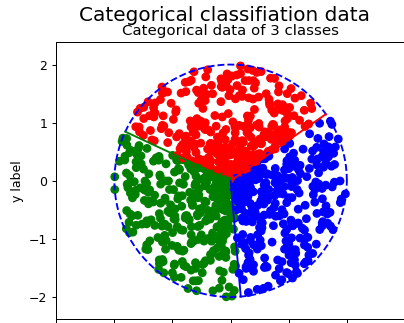

In [37]:
# Radius of a circle within which to place plots.
radius = 2   

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,4))
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()

ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
# Classify plots (x, y) if inside the coverage sector
# labels to classify outside/0/red or inside/1/green.
# --------------------------------------------------------------------------------
Y = COLOR_LABELS[
    T
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X[::,0], X[::,1], marker='o', color=Y)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B.shape[0]):
    ax.plot((0, radius * B[i, 0]), (0, radius * B[i, 1]), COLOR_LABELS[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

plt.draw()
plt.show()


### Train on linearly separable multiple categories

In [38]:
MAX_TEST_TIMES = 500
W = weights.he(M, D+1)
W_backup = copy.deepcopy(W)
optimizer = SGD(lr=0.5)

# W = train_classifier(
W = train_matmul_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

Expected dL/dW 
[[ 0.          0.          0.        ]
 [-0.01137763  0.10633132  0.07066545]
 [ 0.10700262 -0.09869929  0.04252799]]
Diff
[[ 0.          0.          0.        ]
 [ 0.01202895 -0.01165883 -0.00226975]
 [-0.01099299  0.01187132 -0.00237202]]


iteration 0 Loss 1.0474374766911634
iteration 10 Loss 0.9501867049799004
iteration 20 Loss 0.9275263142571222
iteration 30 Loss 0.9164925453759984
iteration 40 Loss 0.9096747238894777
iteration 50 Loss 0.9049874052005645
iteration 60 Loss 0.9015952970074788
iteration 70 Loss 0.8990180405692679
iteration 80 Loss 0.8970883188401174
iteration 90 Loss 0.8955782123183262
iteration 100 Loss 0.894405884544783
iteration 110 Loss 0.8934547140260375
iteration 120 Loss 0.8926833719181948
iteration 130 Loss 0.8920511454071625
iteration 140 Loss 0.8915256577622783
iteration 150 Loss 0.8910914107957697
iteration 160 Loss 0.8907331950397492
iteration 170 Loss 0.8904276997798731
iteration 180 Loss 0.890168838944784
iteration 190 Loss 0.8899423543519107
iteration 200 Loss 0.8897522934538165
iteration 210 Loss 0.8895921920333136
iteration 220 Loss 0.8894588373273712
iteration 230 Loss 0.8893459060951585
iteration 240 Loss 0.8892493101887405
iteration 250 Loss 0.8891634682368221
iteration 260 Loss 0.8890

### Run predictions

Run preditions against the grid coordinates (x1, x2).
```
x1: X[:, 1].min() - 1 <= x1 <=  X[:, 1].max() + 1
x2: X[:, 2].min() - 1 <= x2 <=  X[:, 2].max() + 1
grid = np.meshgrid(x1, x2)

# np.argmax(scores) selets the highest score for each data point in X.
# e.g score[i] = [0.2, 8.2, 0.3], then np.argmax(scores[i]) selects index 1 as the prediction. 
# Then cluster of predition/label == 1 will form a contour.
sores = grid @ W.T
predictions = p.argmax(score, axis=1)
```

### Plot predictions

<IPython.core.display.Javascript object>


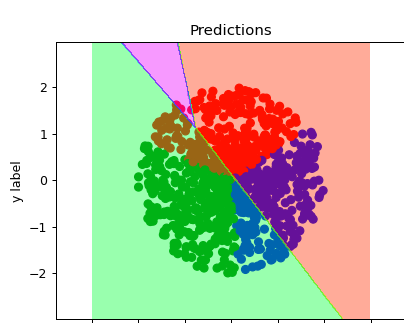

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/functions.py:57: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [39]:
fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
ax.set_title("Predictions")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

plt.show()

## Batch normalization
Observe the effect of the batch normalization by inserting the layer in-between activation and matmul layers.

In [40]:
%reload_ext autoreload
%autoreload 2
from network import (
    train_matmul_bn_relu_classifier
)
from common import (
    prediction_grid_2d
)

In [41]:
MAX_TEST_TIMES = 200
np.copyto(X, X_backup)
np.copyto(W, W_backup)
optimizer = SGD(lr=0.5)

# W = train_classifier(
W, objective, prediction = train_matmul_bn_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

iteration 0 Loss 0.9870223002550319
iteration 10 Loss 0.8792579800577095
iteration 20 Loss 0.8675917221682994
iteration 30 Loss 0.8568381687257456
iteration 40 Loss 0.8468771887310296
iteration 50 Loss 0.8375832624378929
iteration 60 Loss 0.8289109227573637
iteration 70 Loss 0.8208794386909315
iteration 80 Loss 0.8134029594659228
iteration 90 Loss 0.8064379264526866
iteration 100 Loss 0.7999243754258027
iteration 110 Loss 0.7938196023431294
iteration 120 Loss 0.7880755435172712
iteration 130 Loss 0.7826763989091952
iteration 140 Loss 0.7775871166945101
iteration 150 Loss 0.7727573140663988
iteration 160 Loss 0.7681927692560467
iteration 170 Loss 0.7638673431902098
iteration 180 Loss 0.7597537874625364
iteration 190 Loss 0.7558527081967902


<IPython.core.display.Javascript object>


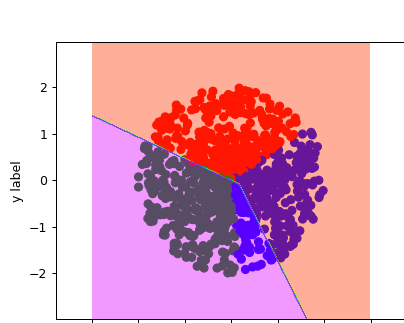

In [42]:
fig, ax = plt.subplots(figsize=(5,4)) 
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
Y = COLOR_LABELS[T]

x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()

## Non-linearly separable data

In [43]:
%reload_ext autoreload
%autoreload 2

from data import (
    set_in_a_radius,
    sets_of_circle_A_not_B
)
from common import (
    prediction_grid_2d
)
from network import (
    train_two_layer_classifier
)

### Data X and Label T
Training data set that cannot be linearly classified. ```X = ((A not B), (B not C), (C not A), (A and B and C and D))``` for circles A, B, C.

<IPython.core.display.Javascript object>


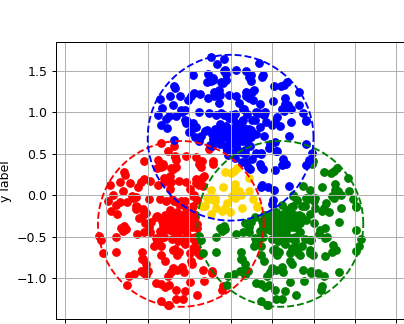

In [44]:
__M = 3        # Number of circles
__N = 300
radius = 1
circles, centres, intersection = sets_of_circle_A_not_B(radius=radius, ratio=1.2, m=__M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

# (A not B), (B not C), (C not A)
for i in range(__M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

# (A and B and C and D)
M = __M + 1
ax.scatter(intersection[::, 0], intersection[::, 1], color='gold')

In [45]:
# Stack all circles and intersect
X = np.vstack(
    [circles[i] for i in range(M-1)] + 
    [intersection]
)

T = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M-1)] + 
    [np.full(intersection.shape[0], M-1)]
)
N = T.shape[0]
assert T.shape[0] == X.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T.shape[0]))
X = X[indices]
T = T[indices]
Y = COLOR_LABELS[T]


print(f"X:{X.shape} T:{T.shape} ")

X:(735, 2) T:(735,) 


### Train on non-linear separable data

In [46]:
MAX_TEST_TIMES = 20000
D = 2
M1 = 8
W1 = weights.he(M1, D+1)
M2: int = M                 # Number of categories to classify
W2 = weights.he(M2, M1+1)
optimizer = SGD(lr=0.5)

X, T = transform_X_T(X, T)
W1, W2, objective, prediction = train_two_layer_classifier(
    N=N,
    D=D,
    X=X,
    T=T,
    M1=M1,
    W1=W1,
    M2=M2,
    W2=W2,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

iteration 0 Loss 1.4781491990215119
iteration 100 Loss 0.9995276033328853
iteration 200 Loss 0.9856356396858076
iteration 300 Loss 0.9788630857995566
iteration 400 Loss 0.9741589408429162
iteration 500 Loss 0.9706420336459669
iteration 600 Loss 0.9675378543200893
iteration 700 Loss 0.9655400806005252
iteration 800 Loss 0.9641157676036454
iteration 900 Loss 0.9630374995676075
iteration 1000 Loss 0.9622015028752122
iteration 1100 Loss 0.9615080983394648
iteration 1200 Loss 0.9609516928915636
iteration 1300 Loss 0.9604964383327721
iteration 1400 Loss 0.9600076268474782
iteration 1500 Loss 0.9595492848557925
iteration 1600 Loss 0.959152166444229
iteration 1700 Loss 0.9588037215160465
iteration 1800 Loss 0.958488912770442
iteration 1900 Loss 0.9582054949010271
iteration 2000 Loss 0.9579529107750616
iteration 2100 Loss 0.9577265732590273
iteration 2200 Loss 0.9575185370636402
iteration 2300 Loss 0.9573226075979852
iteration 2400 Loss 0.9571366743778272
iteration 2500 Loss 0.9569599108282247


Iteration [3390]: Loss[0.955782029672935] has not improved from the previous [0.9557819459039996] for 1 times.


iteration 3400 Loss 0.9557719605043153


Iteration [3449]: Loss[0.9557298901488396] has not improved from the previous [0.9557297311993841] for 1 times.
Iteration [3497]: Loss[0.9556930163901366] has not improved from the previous [0.9556928167162186] for 1 times.


iteration 3500 Loss 0.9556901712300216


Iteration [3529]: Loss[0.9556713462991853] has not improved from the previous [0.955671195907465] for 1 times.
Iteration [3534]: Loss[0.9556681873863391] has not improved from the previous [0.955668171349897] for 1 times.
Iteration [3600]: Loss[0.9556329303010205] has not improved from the previous [0.9556329207740898] for 1 times.


iteration 3600 Loss 0.9556329303010205


Iteration [3643]: Loss[0.9556126153743071] has not improved from the previous [0.9556125435787894] for 1 times.
Iteration [3648]: Loss[0.9556105122572885] has not improved from the previous [0.9556103799483815] for 1 times.
Iteration [3654]: Loss[0.9556081753712267] has not improved from the previous [0.9556081231243891] for 1 times.
Iteration [3659]: Loss[0.9556065396629676] has not improved from the previous [0.9556063183189347] for 1 times.
Iteration [3662]: Loss[0.9556055096993006] has not improved from the previous [0.95560549170677] for 1 times.
Iteration [3669]: Loss[0.9556034497436247] has not improved from the previous [0.9556034332385492] for 1 times.
Iteration [3675]: Loss[0.9556019827009897] has not improved from the previous [0.9556018968287452] for 1 times.
Iteration [3678]: Loss[0.9556012910826184] has not improved from the previous [0.9556012318298024] for 1 times.
Iteration [3685]: Loss[0.9555997757962421] has not improved from the previous [0.9555997481788292] for 1 t

iteration 3700 Loss 0.9555970271684895


Iteration [3715]: Loss[0.9555952084120721] has not improved from the previous [0.955595163271061] for 1 times.
Iteration [3718]: Loss[0.9555948600345876] has not improved from the previous [0.9555948551411456] for 1 times.
Iteration [3727]: Loss[0.9555939516009786] has not improved from the previous [0.9555939345501113] for 1 times.
Iteration [3734]: Loss[0.9555933619178348] has not improved from the previous [0.9555932928154324] for 1 times.
Iteration [3740]: Loss[0.9555928528255111] has not improved from the previous [0.9555928045780612] for 1 times.
Iteration [3747]: Loss[0.9555923122912726] has not improved from the previous [0.9555923046339262] for 1 times.
Iteration [3754]: Loss[0.9555918847175359] has not improved from the previous [0.9555918298978092] for 1 times.
Iteration [3760]: Loss[0.9555915142237108] has not improved from the previous [0.9555914692541517] for 1 times.
Iteration [3767]: Loss[0.9555911204437256] has not improved from the previous [0.9555911000766318] for 1 

iteration 3800 Loss 0.9555896469282097


Iteration [3835]: Loss[0.9555886572043916] has not improved from the previous [0.9555886314206011] for 1 times.
Iteration [3842]: Loss[0.955588487378386] has not improved from the previous [0.9555884672820267] for 1 times.
Iteration [3849]: Loss[0.9555883342889192] has not improved from the previous [0.9555883190688035] for 1 times.
Iteration [3857]: Loss[0.9555881752470493] has not improved from the previous [0.9555881694156795] for 1 times.
Iteration [3864]: Loss[0.955588050880673] has not improved from the previous [0.955588048530832] for 1 times.
Iteration [3867]: Loss[0.9555880039517362] has not improved from the previous [0.9555880026261795] for 1 times.
Iteration [3877]: Loss[0.9555878653332298] has not improved from the previous [0.9555878575706604] for 1 times.
Iteration [3884]: Loss[0.9555877740913047] has not improved from the previous [0.9555877686266168] for 1 times.
Iteration [3891]: Loss[0.955587691794728] has not improved from the previous [0.955587688333467] for 1 time

iteration 3900 Loss 0.955587593857618


Iteration [3913]: Loss[0.9555874755296049] has not improved from the previous [0.9555874692282573] for 1 times.
Iteration [3920]: Loss[0.9555874151707796] has not improved from the previous [0.9555874101350956] for 1 times.
Iteration [3927]: Loss[0.9555873607179439] has not improved from the previous [0.9555873567946223] for 1 times.
Iteration [3934]: Loss[0.9555873115913115] has not improved from the previous [0.9555873086476295] for 1 times.
Iteration [3941]: Loss[0.9555872672683736] has not improved from the previous [0.9555872651891134] for 1 times.
Iteration [3956]: Loss[0.9555871862219892] has not improved from the previous [0.9555871815881173] for 1 times.
Iteration [3963]: Loss[0.955587150156157] has not improved from the previous [0.9555871461718235] for 1 times.
Iteration [3970]: Loss[0.9555871176141121] has not improved from the previous [0.9555871142055261] for 1 times.
Iteration [3977]: Loss[0.9555870882509064] has not improved from the previous [0.9555870853534301] for 1 

iteration 4000 Loss 0.95558700723152


Iteration [4014]: Loss[0.9555869747352214] has not improved from the previous [0.9555869721557515] for 1 times.
Iteration [4021]: Loss[0.9555869588848395] has not improved from the previous [0.9555869565571463] for 1 times.
Iteration [4029]: Loss[0.955586942399741] has not improved from the previous [0.9555869408143395] for 1 times.
Iteration [4036]: Loss[0.9555869294927763] has not improved from the previous [0.9555869281075529] for 1 times.
Iteration [4043]: Loss[0.9555869178451708] has not improved from the previous [0.9555869166392906] for 1 times.
Iteration [4050]: Loss[0.9555869073339635] has not improved from the previous [0.9555869062888691] for 1 times.
Iteration [4058]: Loss[0.9555868964014002] has not improved from the previous [0.9555868958429158] for 1 times.
Iteration [4065]: Loss[0.9555868878413912] has not improved from the previous [0.95558688741172] for 1 times.
Iteration [4072]: Loss[0.9555868801163908] has not improved from the previous [0.9555868798023961] for 1 ti

iteration 4100 Loss 0.9555868541319781


Iteration [4130]: Loss[0.9555868363246366] has not improved from the previous [0.9555868361639828] for 1 times.
Iteration [4137]: Loss[0.9555868329258962] has not improved from the previous [0.9555868328143177] for 1 times.
Iteration [4152]: Loss[0.9555868267094871] has not improved from the previous [0.9555868263718296] for 1 times.
Iteration [4159]: Loss[0.9555868239413955] has not improved from the previous [0.9555868236433971] for 1 times.
Iteration [4166]: Loss[0.9555868214432357] has not improved from the previous [0.9555868211809693] for 1 times.
Iteration [4174]: Loss[0.9555868188447784] has not improved from the previous [0.9555868186958705] for 1 times.
Iteration [4181]: Loss[0.955586816810092] has not improved from the previous [0.9555868166901675] for 1 times.
Iteration [4188]: Loss[0.9555868149738105] has not improved from the previous [0.955586814880011] for 1 times.
Iteration [4195]: Loss[0.9555868133165852] has not improved from the previous [0.9555868132463373] for 1 t

iteration 4200 Loss 0.9555868120117833


Iteration [4224]: Loss[0.9555868077175025] has not improved from the previous [0.9555868075726879] for 1 times.
Iteration [4232]: Loss[0.9555868064504244] has not improved from the previous [0.9555868063607076] for 1 times.
Iteration [4239]: Loss[0.9555868054582451] has not improved from the previous [0.9555868053825346] for 1 times.
Iteration [4246]: Loss[0.9555868045628089] has not improved from the previous [0.9555868044997315] for 1 times.
Iteration [4253]: Loss[0.9555868037546823] has not improved from the previous [0.9555868037029999] for 1 times.
Iteration [4261]: Loss[0.9555868029141001] has not improved from the previous [0.9555868028989363] for 1 times.
Iteration [4264]: Loss[0.9555868026335828] has not improved from the previous [0.9555868026304452] for 1 times.
Iteration [4274]: Loss[0.9555868018253756] has not improved from the previous [0.9555868017634334] for 1 times.
Iteration [4282]: Loss[0.9555868012074787] has not improved from the previous [0.9555868011723689] for 1

iteration 4300 Loss 0.9555867999989298


Iteration [4317]: Loss[0.9555867992444721] has not improved from the previous [0.9555867992167257] for 1 times.
Iteration [4325]: Loss[0.9555867989105917] has not improved from the previous [0.955586798897335] for 1 times.
Iteration [4332]: Loss[0.9555867986491463] has not improved from the previous [0.9555867986395601] for 1 times.
Iteration [4339]: Loss[0.9555867984131922] has not improved from the previous [0.9555867984069182] for 1 times.
Iteration [4354]: Loss[0.9555867979816162] has not improved from the previous [0.9555867979594792] for 1 times.
Iteration [4361]: Loss[0.9555867977894309] has not improved from the previous [0.9555867977699903] for 1 times.
Iteration [4368]: Loss[0.9555867976159841] has not improved from the previous [0.9555867975989767] for 1 times.
Iteration [4375]: Loss[0.9555867974594485] has not improved from the previous [0.9555867974446369] for 1 times.
Iteration [4383]: Loss[0.9555867972966253] has not improved from the previous [0.955586797288877] for 1 t

iteration 4400 Loss 0.9555867970078432


Iteration [4426]: Loss[0.9555867966652839] has not improved from the previous [0.9555867966556971] for 1 times.
Iteration [4433]: Loss[0.9555867965889459] has not improved from the previous [0.9555867965804291] for 1 times.
Iteration [4441]: Loss[0.9555867965095416] has not improved from the previous [0.9555867965044686] for 1 times.
Iteration [4448]: Loss[0.9555867964473639] has not improved from the previous [0.9555867964431622] for 1 times.
Iteration [4455]: Loss[0.9555867963912485] has not improved from the previous [0.9555867963878334] for 1 times.
Iteration [4463]: Loss[0.9555867963328792] has not improved from the previous [0.9555867963319954] for 1 times.
Iteration [4466]: Loss[0.9555867963135679] has not improved from the previous [0.9555867963131821] for 1 times.
Iteration [4476]: Loss[0.9555867962572788] has not improved from the previous [0.9555867962531409] for 1 times.
Iteration [4484]: Loss[0.955586796214372] has not improved from the previous [0.9555867962120949] for 1 

iteration 4500 Loss 0.9555867961386578


Iteration [4520]: Loss[0.955586796073031] has not improved from the previous [0.955586796070192] for 1 times.
Iteration [4527]: Loss[0.9555867960507413] has not improved from the previous [0.9555867960482145] for 1 times.
Iteration [4534]: Loss[0.9555867960306247] has not improved from the previous [0.9555867960283798] for 1 times.
Iteration [4542]: Loss[0.9555867960097002] has not improved from the previous [0.9555867960083627] for 1 times.
Iteration [4549]: Loss[0.9555867959933152] has not improved from the previous [0.9555867959922072] for 1 times.
Iteration [4556]: Loss[0.9555867959785277] has not improved from the previous [0.9555867959776269] for 1 times.
Iteration [4563]: Loss[0.9555867959651819] has not improved from the previous [0.9555867959644683] for 1 times.
Iteration [4571]: Loss[0.9555867959513002] has not improved from the previous [0.9555867959511885] for 1 times.
Iteration [4574]: Loss[0.9555867959468058] has not improved from the previous [0.9555867959466158] for 1 t

iteration 4600 Loss 0.9555867959132043


Iteration [4621]: Loss[0.9555867958947238] has not improved from the previous [0.9555867958940081] for 1 times.
Iteration [4628]: Loss[0.95558679588885] has not improved from the previous [0.9555867958882167] for 1 times.
Iteration [4635]: Loss[0.9555867958835489] has not improved from the previous [0.9555867958829899] for 1 times.
Iteration [4642]: Loss[0.9555867958787648] has not improved from the previous [0.9555867958782727] for 1 times.
Iteration [4650]: Loss[0.9555867958737883] has not improved from the previous [0.955586795873512] for 1 times.
Iteration [4657]: Loss[0.9555867958698915] has not improved from the previous [0.9555867958696699] for 1 times.
Iteration [4664]: Loss[0.9555867958663746] has not improved from the previous [0.9555867958662023] for 1 times.
Iteration [4672]: Loss[0.9555867958627166] has not improved from the previous [0.9555867958627028] for 1 times.
Iteration [4675]: Loss[0.9555867958615478] has not improved from the previous [0.9555867958614821] for 1 ti

iteration 4700 Loss 0.9555867958531838


Iteration [4710]: Loss[0.955586795850547] has not improved from the previous [0.9555867958505442] for 1 times.
Iteration [4721]: Loss[0.9555867958482104] has not improved from the previous [0.955586795848099] for 1 times.
Iteration [4728]: Loss[0.9555867958468135] has not improved from the previous [0.9555867958467217] for 1 times.
Iteration [4736]: Loss[0.9555867958453603] has not improved from the previous [0.9555867958453316] for 1 times.
Iteration [4739]: Loss[0.9555867958448729] has not improved from the previous [0.95558679584487] for 1 times.
Iteration [4749]: Loss[0.9555867958434784] has not improved from the previous [0.9555867958433686] for 1 times.
Iteration [4757]: Loss[0.9555867958424104] has not improved from the previous [0.9555867958423468] for 1 times.
Iteration [4764]: Loss[0.9555867958415739] has not improved from the previous [0.9555867958415221] for 1 times.
Iteration [4771]: Loss[0.9555867958408191] has not improved from the previous [0.9555867958407779] for 1 tim

iteration 4800 Loss 0.9555867958384396


Iteration [4821]: Loss[0.9555867958372117] has not improved from the previous [0.9555867958372031] for 1 times.
Iteration [4824]: Loss[0.9555867958370691] has not improved from the previous [0.9555867958370685] for 1 times.
Iteration [4835]: Loss[0.9555867958366163] has not improved from the previous [0.9555867958365949] for 1 times.
Iteration [4843]: Loss[0.9555867958363046] has not improved from the previous [0.9555867958362967] for 1 times.
Iteration [4850]: Loss[0.9555867958360603] has not improved from the previous [0.9555867958360557] for 1 times.
Iteration [4853]: Loss[0.9555867958359668] has not improved from the previous [0.9555867958359653] for 1 times.
Iteration [4864]: Loss[0.9555867958356654] has not improved from the previous [0.9555867958356523] for 1 times.
Iteration [4871]: Loss[0.9555867958354859] has not improved from the previous [0.9555867958354751] for 1 times.
Iteration [4878]: Loss[0.9555867958353237] has not improved from the previous [0.9555867958353154] for 1

iteration 4900 Loss 0.9555867958349101


Iteration [4914]: Loss[0.9555867958346836] has not improved from the previous [0.9555867958346707] for 1 times.
Iteration [4921]: Loss[0.9555867958345865] has not improved from the previous [0.955586795834575] for 1 times.
Iteration [4929]: Loss[0.9555867958344857] has not improved from the previous [0.9555867958344786] for 1 times.
Iteration [4936]: Loss[0.9555867958344069] has not improved from the previous [0.9555867958344006] for 1 times.
Iteration [4943]: Loss[0.9555867958343354] has not improved from the previous [0.9555867958343303] for 1 times.
Iteration [4951]: Loss[0.9555867958342614] has not improved from the previous [0.9555867958342592] for 1 times.
Iteration [4958]: Loss[0.9555867958342033] has not improved from the previous [0.955586795834202] for 1 times.
Iteration [4961]: Loss[0.9555867958341809] has not improved from the previous [0.9555867958341805] for 1 times.
Iteration [4972]: Loss[0.9555867958341092] has not improved from the previous [0.9555867958341061] for 1 t

iteration 5000 Loss 0.9555867958339608


Iteration [5015]: Loss[0.9555867958339066] has not improved from the previous [0.9555867958339054] for 1 times.
Iteration [5022]: Loss[0.9555867958338834] has not improved from the previous [0.9555867958338825] for 1 times.
Iteration [5029]: Loss[0.9555867958338626] has not improved from the previous [0.9555867958338621] for 1 times.
Iteration [5036]: Loss[0.9555867958338438] has not improved from the previous [0.9555867958338435] for 1 times.
Iteration [5044]: Loss[0.9555867958338264] has not improved from the previous [0.955586795833824] for 1 times.
Iteration [5051]: Loss[0.9555867958338111] has not improved from the previous [0.9555867958338088] for 1 times.
Iteration [5059]: Loss[0.9555867958337952] has not improved from the previous [0.9555867958337937] for 1 times.
Iteration [5066]: Loss[0.9555867958337827] has not improved from the previous [0.9555867958337813] for 1 times.
Iteration [5073]: Loss[0.9555867958337714] has not improved from the previous [0.9555867958337702] for 1 

iteration 5100 Loss 0.9555867958337356


Iteration [5113]: Loss[0.9555867958337247] has not improved from the previous [0.9555867958337245] for 1 times.
Iteration [5123]: Loss[0.9555867958337171] has not improved from the previous [0.9555867958337166] for 1 times.
Iteration [5131]: Loss[0.9555867958337114] has not improved from the previous [0.9555867958337111] for 1 times.
Iteration [5138]: Loss[0.9555867958337071] has not improved from the previous [0.9555867958337068] for 1 times.
Iteration [5141]: Loss[0.9555867958337052] has not improved from the previous [0.9555867958337052] for 1 times.
Iteration [5152]: Loss[0.9555867958336997] has not improved from the previous [0.9555867958336993] for 1 times.
Iteration [5159]: Loss[0.9555867958336964] has not improved from the previous [0.9555867958336961] for 1 times.
Iteration [5166]: Loss[0.9555867958336934] has not improved from the previous [0.9555867958336931] for 1 times.
Iteration [5169]: Loss[0.9555867958336922] has not improved from the previous [0.9555867958336922] for 1

iteration 5200 Loss 0.9555867958336842


Iteration [5217]: Loss[0.9555867958336823] has not improved from the previous [0.9555867958336823] for 1 times.
Iteration [5218]: Loss[0.9555867958336823] has not improved from the previous [0.9555867958336823] for 2 times.
Iteration [5220]: Loss[0.9555867958336821] has not improved from the previous [0.9555867958336821] for 1 times.
Iteration [5222]: Loss[0.955586795833682] has not improved from the previous [0.955586795833682] for 1 times.
Iteration [5223]: Loss[0.955586795833682] has not improved from the previous [0.955586795833682] for 2 times.
Iteration [5225]: Loss[0.9555867958336819] has not improved from the previous [0.9555867958336819] for 1 times.
Iteration [5226]: Loss[0.9555867958336819] has not improved from the previous [0.9555867958336819] for 2 times.
Iteration [5227]: Loss[0.9555867958336819] has not improved from the previous [0.9555867958336819] for 3 times.
Iteration [5229]: Loss[0.9555867958336817] has not improved from the previous [0.9555867958336817] for 1 tim

Iteration [5277]: Loss[0.9555867958336813] has not improved from the previous [0.9555867958336813] for 31 times.
W has not been updated. Before=
[[ 0.2710187   0.55743528 -0.02940284]
 [-1.10886762  3.80161297 -1.50536735]
 [ 0.09534126  0.34564225  1.11431787]
 [-0.03298058 -0.1159084   0.69620547]
 [-0.37426916  0.02109663 -0.38915414]
 [-0.59283693  1.73957039 -0.39702793]
 [-0.63620449  1.2559404   2.53370484]
 [-1.07907611  1.42919636  3.59161944]]
After=
[[ 0.2710187   0.55743528 -0.02940284]
 [-1.10886762  3.80161297 -1.50536735]
 [ 0.09534126  0.34564225  1.11431787]
 [-0.03298058 -0.1159084   0.69620547]
 [-0.37426916  0.02109663 -0.38915414]
 [-0.59283693  1.73957039 -0.39702793]
 [-0.63620449  1.2559404   2.53370484]
 [-1.07907611  1.42919636  3.59161944]]
Diff=
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
dW=
[[ 2.34572223e-07 -2.46559642e-07  1.58206930e-07]
 [ 4.65461682e-04 -6.26786688e-04  2.51126323e-05]
 [-2.39119411

Iteration [5284]: Loss[0.9555867958336813] has not improved from the previous [0.9555867958336813] for 38 times.
W has not been updated. Before=
[[ 0.2710187   0.55743528 -0.02940284]
 [-1.10886762  3.80161297 -1.50536735]
 [ 0.09534126  0.34564225  1.11431787]
 [-0.03298058 -0.1159084   0.69620547]
 [-0.37426916  0.02109663 -0.38915414]
 [-0.59283693  1.73957039 -0.39702793]
 [-0.63620449  1.2559404   2.53370484]
 [-1.07907611  1.42919636  3.59161944]]
After=
[[ 0.2710187   0.55743528 -0.02940284]
 [-1.10886762  3.80161297 -1.50536735]
 [ 0.09534126  0.34564225  1.11431787]
 [-0.03298058 -0.1159084   0.69620547]
 [-0.37426916  0.02109663 -0.38915414]
 [-0.59283693  1.73957039 -0.39702793]
 [-0.63620449  1.2559404   2.53370484]
 [-1.07907611  1.42919636  3.59161944]]
Diff=
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
dW=
[[ 2.34572223e-07 -2.46559642e-07  1.58206930e-07]
 [ 4.65461682e-04 -6.26786688e-04  2.51126323e-05]
 [-2.39119411

Iteration [5291]: Loss[0.9555867958336813] has not improved from the previous [0.9555867958336813] for 45 times.
W has not been updated. Before=
[[ 0.2710187   0.55743528 -0.02940284]
 [-1.10886762  3.80161297 -1.50536735]
 [ 0.09534126  0.34564225  1.11431787]
 [-0.03298058 -0.1159084   0.69620547]
 [-0.37426916  0.02109663 -0.38915414]
 [-0.59283693  1.73957039 -0.39702793]
 [-0.63620449  1.2559404   2.53370484]
 [-1.07907611  1.42919636  3.59161944]]
After=
[[ 0.2710187   0.55743528 -0.02940284]
 [-1.10886762  3.80161297 -1.50536735]
 [ 0.09534126  0.34564225  1.11431787]
 [-0.03298058 -0.1159084   0.69620547]
 [-0.37426916  0.02109663 -0.38915414]
 [-0.59283693  1.73957039 -0.39702793]
 [-0.63620449  1.2559404   2.53370484]
 [-1.07907611  1.42919636  3.59161944]]
Diff=
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
dW=
[[ 2.34572223e-07 -2.46559642e-07  1.58206930e-07]
 [ 4.65461682e-04 -6.26786688e-04  2.51126323e-05]
 [-2.39119411

### Plot predictions

<IPython.core.display.Javascript object>


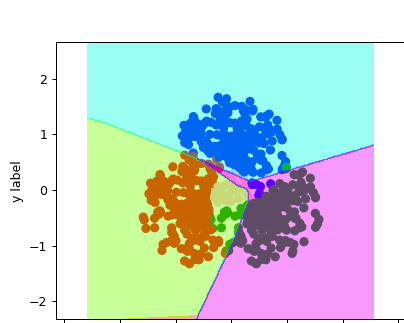

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/functions.py:57: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [47]:
fig, ax = plt.subplots(figsize=(5,4)) 
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
Y = COLOR_LABELS[T]

x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()